In [2]:
import os
import sys
import json
from os.path import join, basename, dirname

import numpy as np
import pandas as pd

import time
from tqdm import tqdm

from feature_analyzer.index.agent import IndexAgent
from feature_analyzer.data_tools.embedding_container import EmbeddingContainer
from feature_analyzer.utils.template_parser import InferenceResult
from feature_analyzer.data_tools.result_container import ResultContainer

import seaborn as sns

In [3]:
data_dir = '/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_D40kv2_RMG/'
#data_dir = '/Users/kv/workspace/feature-analyzer/features/D40kRM'

In [4]:
RMG = InferenceResult('/home/kv_zhao/nist-e2e/outcomes/MERGE_V1/D40kv2_RMG_iv1_pv1/')
#RMG = InferenceResult('/Users/kv/workspace/nist-e2e/outcomes/MERGE_V0/D40kv2_Rms1m_clean/')

Load from /home/kv_zhao/nist-e2e/outcomes/MERGE_V1/D40kv2_RMG_iv1_pv1/
FP: 27525, FN: 2450, NF: 18, WLM:1341


In [5]:
container = EmbeddingContainer()
container.load(data_dir)

Container:embedding_container created
Load embedding container from feat_obj format
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_D40kv2_RMG//embeddings.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_D40kv2_RMG//label_ids.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_D40kv2_RMG//filename_strings.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_D40kv2_RMG//probabilities.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_D40kv2_RMG//label_names.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_D40kv2_RMG//landmarks.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_D40kv2_RMG//instance_ids.npy is loaded
container size: 10000 -> 134281
embedding size: 0 -> 1024
probability size: 0 -> 1
landmark size: 0 -> 10
Reset embedding_container
Index Table Created
Container initialized.


In [6]:
instance_ids = container.instance_ids
all_embeddings = container.get_embedding_by_instance_ids(instance_ids)
agent = IndexAgent('HNSW', instance_ids, all_embeddings, distance_measure='ip')

HNSW Index Agent is initialized with 134281 features


In [7]:
print(container)

=============== embedding_container ===============
embeddings: (134281, 1024)
probabilities: (134281, 1)
landamrks: (134281, 10)
internals: instance_ids, label_ids, label_names, filename_strings
attributes: source



In [ ]:
start = time.time()
label_ids = list(set(container.label_ids))
num_identity = len(label_ids)

total_topk_miss_counts = 0

for label_id in label_ids[3560:3561]:
    same_class_inst_ids = container.get_instance_ids_by_label_ids(label_id)
    same_class_embeddings = container.get_embedding_by_instance_ids(same_class_inst_ids)
    class_center_embedding = np.mean(same_class_embeddings, axis=0)
    class_center_fluct = np.mean(np.std(same_class_embeddings, axis=0))
    
    print(same_class_inst_ids)
    
    # instance
    num_inst_same_class = len(same_class_inst_ids)
    retrieved_indexes, similarities = agent.search(
        same_class_embeddings, top_k = 2 * num_inst_same_class, is_similarity=True)
    retrieved_label_ids = container.get_label_by_instance_ids(retrieved_indexes)
    hits = retrieved_label_ids == np.asarray([label_id])
    
    # top k instance
    topk_hits = hits[:, :num_inst_same_class]
    #np.isin(retrieved_indexes[:, :num_inst_same_class], same_class_inst_ids)
    topk_hit_counts = np.sum(topk_hits, axis=1)
    topk_miss_counts = np.sum(~topk_hits, axis=1)
    topk_purities = topk_hit_counts / num_inst_same_class
    topk_same_class_purity = np.mean(topk_purities)
    
    #print(topk_miss_counts, topk_purities, topk_same_class_purity)
    total_topk_miss_counts += np.sum(topk_miss_counts, axis=0)
    
    # center
    center_retrieved_indexes, center_similarities = agent.search(
        class_center_embedding, top_k = 2 * num_inst_same_class, is_similarity=True)
    center_retrieved_label_ids = container.get_label_by_instance_ids(center_retrieved_indexes)
    center_hits = center_retrieved_label_ids == np.asarray([label_id])
    
    # top k center
    topk_center_hits = center_hits[:, :num_inst_same_class]
    topk_center_hit_counts = np.sum(topk_center_hits, axis=1)
    topk_center_purities = topk_center_hit_counts / num_inst_same_class
    topk_center_same_class_purity = np.mean(topk_center_purities)
    
    
    # top 2k instance
    assert hits.shape == retrieved_label_ids.shape
    for row, (q_id, ret_id, hit_arr, hit_label_arr) in enumerate(
            zip(same_class_inst_ids, retrieved_indexes, hits, retrieved_label_ids)):
        # for each arr, must have negative and positive (self)
        first_neg_id = np.argmax(~hit_arr)
        prev_pos_id = first_neg_id - 1
        last_pos_id = np.where(hit_arr)[-1]

        if last_pos_id.size == 0:
            # event should records
            print('q_id', q_id)
            print('q container label', container.get_label_by_instance_ids(q_id))
            print('ret_id', ret_id)
            print('hit_label_arr', hit_label_arr)
            print('container label', container.get_label_by_instance_ids(ret_id))
            print('hit arr', hit_arr)
            print('sim', similarities[row])
            #print(ret_id)
            #print(label_id)
            #print(same_class_inst_ids[row])
            #print(same_class_inst_ids)
            #print(retrieved_label_ids[row], hit_label_arr)
            continue
        last_pos_id = last_pos_id[-1]
        last_pos_sim = similarities[row, last_pos_id]
        first_neg_sim = similarities[row, first_neg_id]
        margin = first_neg_sim - last_pos_sim
        #print(first_neg_id, last_pos_id, hit_arr, hit_label_arr, margin)
        
    #last_positive_ids = np.asarray(last_positive_ids)
    #first_negative_ids = np.asarray(first_negative_ids)
    

    # if first_neg > last_pos (purity == 1.0) => compute margin
    # otherwise, count how many different classes within.
    #print('hits', hit_label_ids)
    #print('positive ids', positive_ids)
    #print('negative ids', negative_ids)

    #break
    
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

print(total_topk_miss_counts)
print(total_topk_miss_counts / len(container.instance_ids))

## Analysis from results

In [6]:
results = ResultContainer()

In [7]:
res_dir = '/home/kv_zhao/nist-e2e/feature-analyzer/var_mergeV0_D40k_RMG'
results.load(res_dir)

Load results and events from '/home/kv_zhao/nist-e2e/feature-analyzer/var_mergeV0_D40k_RMG'


In [10]:
events = results.events

In [13]:
margin_events = events[events.margin >= 0.0]
no_margin_events = events[events.margin < 0.0]

In [18]:
label_ids = list(map(int, events.label_id.unique()))
label_num_instance_map = {
    label_id: len(container.get_instance_ids_by_label(label_id)) for label_id in label_ids
}

In [26]:
list(margin_events[margin_events.label_id == 1].label_id)

[1.0, 1.0, 1.0, 1.0, 1.0]

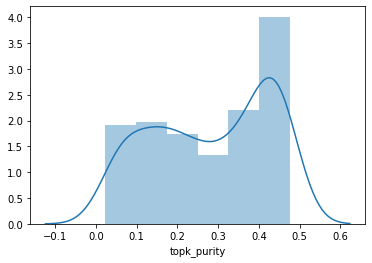

In [31]:
sns.distplot(no_margin_events[
    no_margin_events.topk_purity < .5].topk_purity )

In [36]:
no_margin_events[(no_margin_events.topk_purity < .5) & (no_margin_events.first_neg_sim > 1.3)]

,extend_diversity,first_neg_id,first_neg_sim,instance_id,label_id,last_pos_id,last_pos_sim,margin,ret_ids,ret_label_ids,topk_purity
1048,0.0,2.0,1.349985,1048.0,52.0,11.0,1.293045,-0.056940,"[1048, 1047, 76025, 55097, 10913, 76027, 1050,...","[52, 52, 4045, 2978, 567, 4045, 52, 200, 2978,...",0.333333
1257,0.0,1.0,1.432295,1257.0,64.0,68.0,1.291637,-0.140658,"[1257, 90277, 90279, 90286, 90270, 90284, 9031...","[64, 4764, 4764, 4764, 4764, 4764, 4764, 4764,...",0.054054
1469,0.0,1.0,1.922770,1469.0,77.0,21.0,1.778743,-0.144027,"[1469, 67684, 67660, 67658, 67677, 67665, 6767...","[77, 3630, 3630, 3630, 3630, 3630, 3630, 3630,...",0.235294
1470,0.0,1.0,1.891357,1470.0,77.0,33.0,1.803390,-0.087967,"[1470, 67649, 67668, 67645, 67652, 1475, 67671...","[77, 3630, 3630, 3630, 3630, 77, 3630, 3630, 3...",0.235294
1471,0.0,3.0,1.745524,1471.0,77.0,30.0,1.681921,-0.063603,"[1471, 1472, 1478, 67686, 67665, 67649, 67641,...","[77, 77, 77, 3630, 3630, 3630, 3630, 3630, 77,...",0.294118
...,...,...,...,...,...,...,...,...,...,...,...
112685,0.0,1.0,1.341132,112685.0,5979.0,42.0,1.255983,-0.085150,"[112685, 85019, 11355, 4377, 24796, 102158, 11...","[5979, 4478, 592, 232, 1336, 5425, 592, 4478, ...",0.064516
114127,0.0,18.0,1.373081,114127.0,6054.0,97.0,1.271369,-0.101712,"[114127, 114111, 114129, 114128, 114136, 11412...","[6054, 6054, 6054, 6054, 6054, 6054, 6054, 605...",0.396552
114135,0.0,16.0,1.379302,114135.0,6054.0,103.0,1.242245,-0.137056,"[114135, 114134, 114136, 114121, 114108, 11411...","[6054, 6054, 6054, 6054, 6054, 6054, 6054, 605...",0.344828
115958,0.0,1.0,1.343221,115958.0,6128.0,15.0,1.297459,-0.045763,"[115958, 55826, 47971, 52308, 115960, 35294, 1...","[6128, 3012, 2584, 2829, 6128, 1913, 6261, 403...",0.230769
